# Task 1: Importing Libraries and Helper Functions


In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import random
import imageio

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv3D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv3DTranspose, Reshape, LeakyReLU, Lambda
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


# Task 2: Importing and Plotting the Data

In [2]:
x = []
size = 96
for root, dirs, files in os.walk('../data/Pokemon'):
  for f in files:
    if 'png' not in f.lower():
      continue
    feature = imageio.imread(os.path.join(root, f))
    try:
      resized_feature = np.array(
          Image.fromarray(
              feature,
              mode='RGBA',
          ).resize((size, size))
      )
      x.append(resized_feature / 256)
    except:
      pass
len(x)

14167

In [3]:
x = np.stack(x, axis=0) 

In [4]:
x.shape

(14167, 96, 96, 4)

In [5]:
x[0][:, 50, 0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3515625 , 0.73828125, 0.3515625 , 0.99609375, 0.99609375,
       0.73828125, 0.3515625 , 0.44921875, 0.0625    , 0.0625    ,
       0.0625    , 0.0625    , 0.0625    , 0.3515625 , 0.4140625 ,
       0.703125  , 0.0625    , 0.22265625, 0.22265625, 0.8671875 ,
       0.8671875 , 0.8671875 , 0.8671875 , 0.8671875 , 0.8671875 ,
       0.8671875 , 0.8671875 , 0.22265625, 0.99609375, 0.22265625,
       0.44921875, 0.54296875, 0.54296875, 0.54296875, 0.54296875,
       0.54296875, 0.54296875, 0.44921875, 0.0625    , 0.54296875,
       0.54296875, 0.0625    , 0.0625    , 0.22265625, 0.22265625,
       0.22265625, 0.22265625, 0.8671875 , 0.8671875 , 0.8671875 ,
       0.8671875 , 0.8671875 , 0.22265625, 0.44921875, 0.44921875,
       0.44921875, 0.3515625 , 0.0625    , 0.        , 0.     

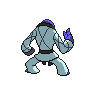

In [6]:
def Plot(image):
  return Image.fromarray((image * 256).astype(np.uint8))

Plot(random.choice(x))

In [7]:
x[0].shape

(96, 96, 4)

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [8]:

channels = 4
noise_dim = 2

discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(size, size, channels)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 64)        2368      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 47, 47, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 22, 22, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 256)         8

# Task 4: Generator

In [9]:
generator = Sequential([
    Dense(1024, activation='relu', input_shape=(noise_dim,)),
    Reshape((1, 1, 1024)),
    
    Conv2DTranspose(512, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(128, 5, strides=2, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(32, 5, strides=2, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(4, 4, activation='sigmoid'),
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              3072      
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 512)         13107712  
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 256)         3277056   
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 128)      

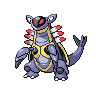

In [10]:
noise = np.random.randn(1, noise_dim)
gen_image = generator.predict(noise)[0]

assert gen_image.shape == x[0].shape
Plot(x[0])

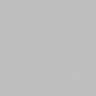

In [11]:
Plot(gen_image)

# Task 5: Generative Adversarial Network (GAN)

In [12]:
input_layer = tf.keras.layers.Input(shape=(noise_dim,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 96, 96, 4)         17469284  
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1049281   
Total params: 18,518,565
Trainable params: 17,467,300
Non-trainable params: 1,051,265
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [27]:
%%time

epochs = 25
num_examples, *_ = x.shape
batch_size = num_examples // 3
steps_per_epoch = 2 * num_examples //batch_size

print('Steps per epoch=', steps_per_epoch)


for e in range(0, epochs):
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], size, size, channels))

        noise = np.random.randn(int(batch_size/2), noise_dim)
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0)
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]

        # train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        # train the generator
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))

        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
    
    gan.save('pokemon_gan')
    generator.save('pokemon_generator')
    discriminator.save('pokemon_discriminator')

    print('DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))

Steps per epoch= 6
INFO:tensorflow:Assets written to: pokemon_gan/assets
INFO:tensorflow:Assets written to: pokemon_generator/assets
INFO:tensorflow:Assets written to: pokemon_discriminator/assets
DiscAcc:0.99 GANLoss:4.60
INFO:tensorflow:Assets written to: pokemon_gan/assets
INFO:tensorflow:Assets written to: pokemon_generator/assets
INFO:tensorflow:Assets written to: pokemon_discriminator/assets
DiscAcc:0.50 GANLoss:0.00
INFO:tensorflow:Assets written to: pokemon_gan/assets
INFO:tensorflow:Assets written to: pokemon_generator/assets
INFO:tensorflow:Assets written to: pokemon_discriminator/assets
DiscAcc:0.50 GANLoss:0.00
INFO:tensorflow:Assets written to: pokemon_gan/assets
INFO:tensorflow:Assets written to: pokemon_generator/assets
INFO:tensorflow:Assets written to: pokemon_discriminator/assets
DiscAcc:0.50 GANLoss:0.00
INFO:tensorflow:Assets written to: pokemon_gan/assets
INFO:tensorflow:Assets written to: pokemon_generator/assets
INFO:tensorflow:Assets written to: pokemon_discrimi

KeyboardInterrupt: 

[[-1.07526367 -0.60872176]]


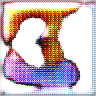

In [28]:
noise = np.random.randn(1, noise_dim)
print(noise)
generated_example = generator.predict(noise)[0]

Plot(generated_example)


In [29]:
gan.save('pokemon_gan')
generator.save('pokemon_generator')
discriminator.save('pokemon_discriminator')

INFO:tensorflow:Assets written to: pokemon_gan/assets
INFO:tensorflow:Assets written to: pokemon_generator/assets
INFO:tensorflow:Assets written to: pokemon_discriminator/assets
